# **Stock Price Prediction using Ensemble Deep Learning Models**

#### 1. LSTM </br> 2. CNN </br> 3. GAN </br> 4. RBFN </br>

### **Step 1: Data Selection**

In [1]:
## Importing the required libraries

import os
import time
import csv
import random
import math
from math import sqrt
import datetime as dt
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from numpy import array
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from pylab import rcParams
from scipy.stats import boxcox
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
from keras import backend as K
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.initializers import RandomUniform, Initializer, Orthogonal, Constant
from pickle import dump
from pickle import load
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.python.keras.layers import Layer, InputSpec
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout

import warnings
warnings.filterwarnings('ignore')

#### Load Data

In [2]:
## Function to load data and store in a dataframe

def load_data(filename):
  df = pd.read_csv(filename, parse_dates=['Date'])
  df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
  df['Date'] = pd.to_datetime(df.Date, format='%m/%d/%y')
  df = df.set_index('Date')
  return df

In [3]:
## Read the stock file using the function load_data

df = load_data('ibm.csv')

In [4]:
## Print the number of rows and columns of the dataframe

df.shape

(2516, 5)

In [5]:
## Print the column names present in the dataframe

df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [6]:
## Print the first few rows of the dataframe

df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2011-05-13,171.70,172.15,169.44,169.92,5168995
2011-05-16,169.81,170.64,168.31,168.86,4662973
2011-05-17,167.85,171.41,166.53,170.50,8793885
2011-05-18,170.10,171.19,169.46,170.44,4157195
2011-05-19,170.86,171.40,169.32,170.59,3540005


In [7]:
## Check the info of the dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2011-05-13 to 2021-05-12
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2516 non-null   float64
 1   High    2516 non-null   float64
 2   Low     2516 non-null   float64
 3   Close   2516 non-null   float64
 4   Volume  2516 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 117.9 KB


### **Step 2: Data Exploration**

In [8]:
## Check the null values in the dataset

df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

There are no NULL values in the dataset, lets proceed further with Time Series Analysis

#### Time Series Analysis

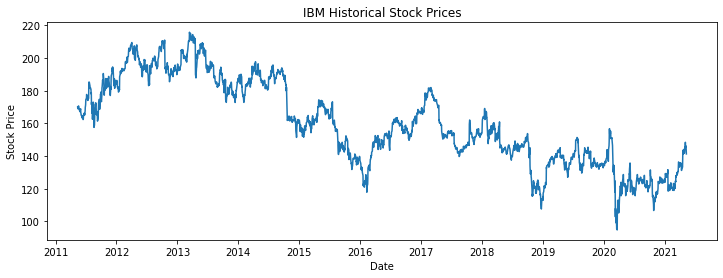

In [9]:
plt.figure(figsize=(12,4))
plt.plot(df['Close'])
plt.title('IBM Historical Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

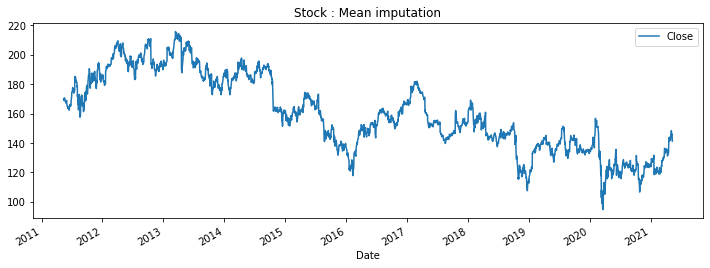

In [10]:
## Mean Imputation Method

df.assign(Stock_Mean_Imputation=df.Close.fillna(df.Close.mean()))['Close'].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Stock : Mean imputation')
plt.show(block=False)

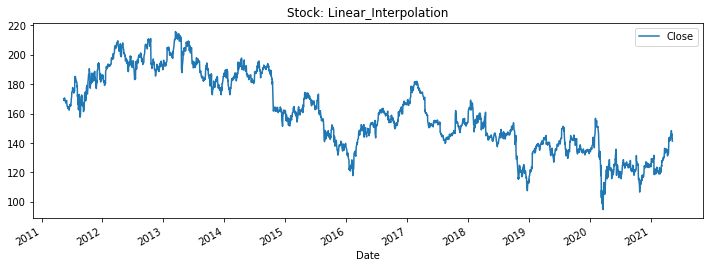

In [11]:
## Linear Interpolation Method

df.assign(Stock_Linear_Interpolation=df['Close'].interpolate(method='linear'))['Close'].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Stock: Linear_Interpolation')
plt.show(block=False)

#### Outlier Detection

Boxplot and InterQuartile Range

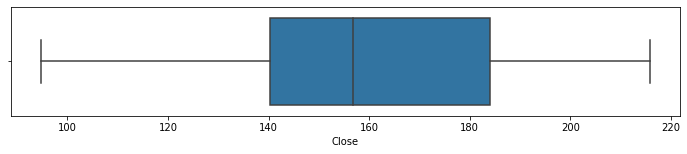

In [12]:
## Plot the Boxplot and IQR

fig = plt.subplots(figsize=(12,2))
ax = sns.boxplot(x=df['Close'], whis=4)

Histogram plot

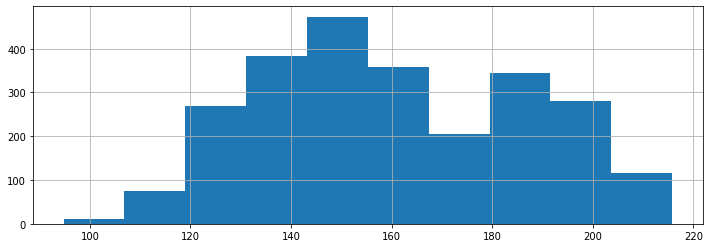

In [13]:
# Plot the Histogram

fig = df.Close.hist(figsize=(12,4))

There are no outliers in this time series data, lets proceed with Time Series Decomposition.

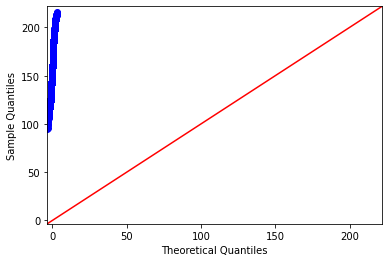

In [14]:
## Q-Q Plot

%matplotlib inline
fig = sm.qqplot(df['Close'], line='45')
plt.show()

#### Time Series Decomposition - Trend, Seasonal and Residual Components

Additive Seasonal decomposition

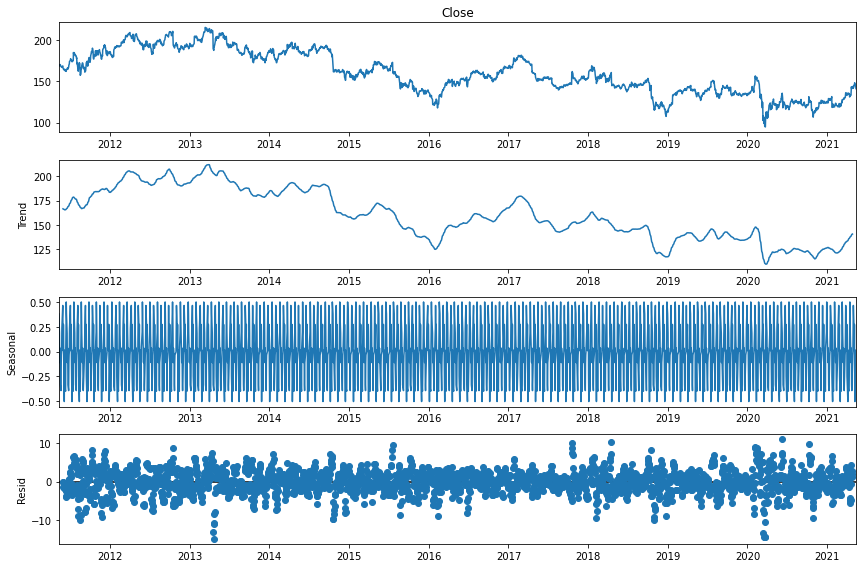

In [15]:
## Plot the Additive Decomposition

rcParams['figure.figsize'] = 12,8
decomposition = sm.tsa.seasonal_decompose(df.Close, model='additive', period=24)
fig = decomposition.plot()
plt.show()

Multiplicative Seasonal decomposition

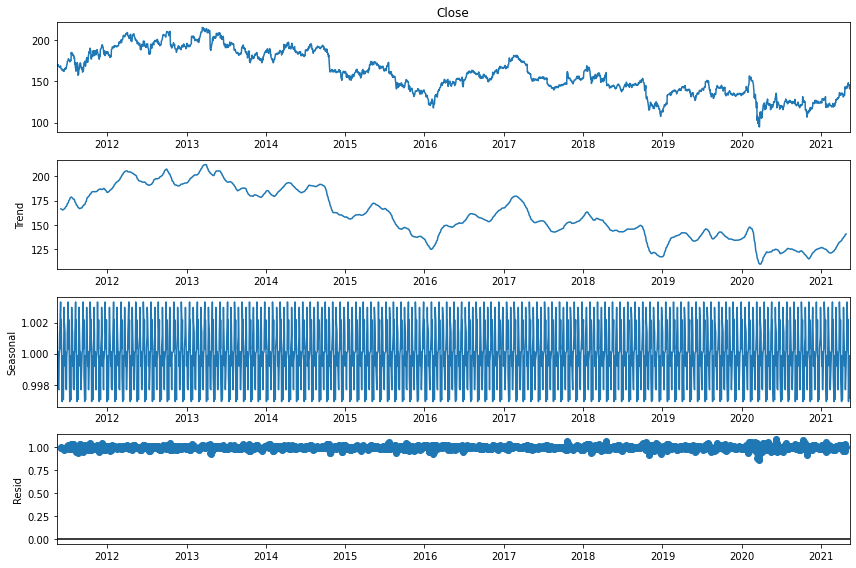

In [16]:
## Plot the Multiplicative Decomposition

decomposition = sm.tsa.seasonal_decompose(df.Close, model='multiplicative', period=24)
fig = decomposition.plot()
plt.show()

#### Stationarity Tests - ADF & KPSS

In [17]:
## Augmented Dickey-Fuller(ADF) Test

adf_test = adfuller(df['Close'])

print('ADF Statistic : %f' % adf_test[0])
print('Critical Value @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value : %f' % adf_test[1])

ADF Statistic : -1.501300
Critical Value @ 0.05: -2.86
p-value : 0.532868


In [18]:
## Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

kpss_test = kpss(df['Close'])

print('KPSS Statistic : %f' % kpss_test[0])
print('Critical Value @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value : %f' % kpss_test[1])

KPSS Statistic : 7.104320
Critical Value @ 0.05: 0.46
p-value : 0.010000


#### Box Cox Transformation and Differencing 

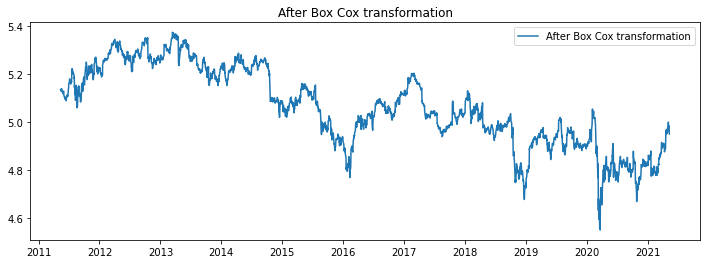

In [19]:
## Box Cox transformation

data_boxcox = pd.Series(boxcox(df['Close'], lmbda=0), index = df.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox transformation')
plt.legend(loc='best')
plt.title('After Box Cox transformation')
plt.show()

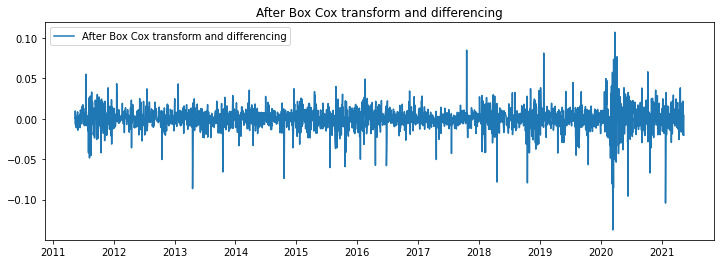

In [20]:
## Differencing

data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), index=df.index)
data_boxcox_diff.dropna(inplace=True)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox transform and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [21]:
## ADF test post BoxCox Transformation and Differencing

adf_test = adfuller(data_boxcox_diff)

print('ADF Statistic : %f' % adf_test[0])
print('Critical Value @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value : %f' % adf_test[1])

ADF Statistic : -12.250990
Critical Value @ 0.05: -2.86
p-value : 0.000000


In [22]:
## KPSS test post BoxCox Transformation and Differencing

kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic : %f' % kpss_test[0])
print('Critical Value @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value : %f' % kpss_test[1])

KPSS Statistic : 0.034285
Critical Value @ 0.05: 0.46
p-value : 0.100000


#### Autocorrelation Function (ACF) plot

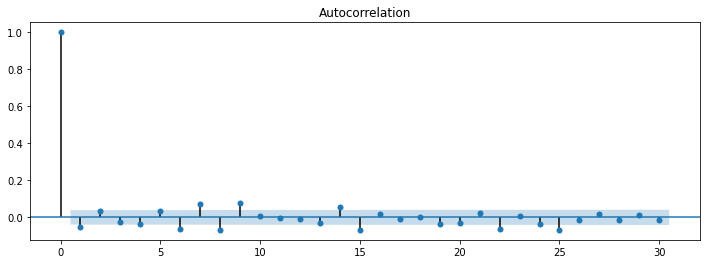

In [23]:
## Plot ACF

plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags=30)
plt.show()

#### Partial Autocorrelation(PACF) plot

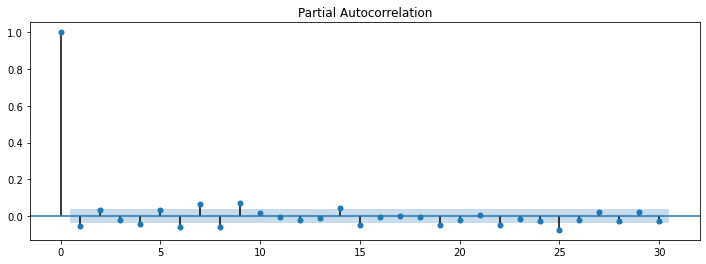

In [24]:
## Plot PACF

plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags=30)
plt.show()

Fetch the Close Price columns of stocks from the dataframe to calculate different metrics mentioned below:

- Daily Returns
- Annualized Returns
- Mean value of Returns
- Summary Statistics like Count, Minimum, Maximum, Median
- Risk/Volatility i.e. Standard Deviation
- Cumulative Returns

In [25]:
## Get the Close Price from the dataframe to perform different metrics

cols = df.columns[df.columns.str.contains('Close')]
cols

Index(['Close'], dtype='object')

In [26]:
## Create a dataframe which contains only Close Price of Stocks

stock_price = df[cols]
stock_price.head()

,Close
Date,
2011-05-13,169.92
2011-05-16,168.86
2011-05-17,170.50
2011-05-18,170.44
2011-05-19,170.59


In [27]:
## Check the shape of the dataframe

stock_price.shape

(2516, 1)

In [28]:
## Create the Normalised Stock Prices dataframe

norm_stock_price = stock_price/np.array(stock_price[:1])
norm_stock_price.head()

,Close
Date,
2011-05-13,1.000000
2011-05-16,0.993762
2011-05-17,1.003413
2011-05-18,1.003060
2011-05-19,1.003943


In [29]:
## Check the rows and columns of the dataframe

norm_stock_price.shape

(2516, 1)

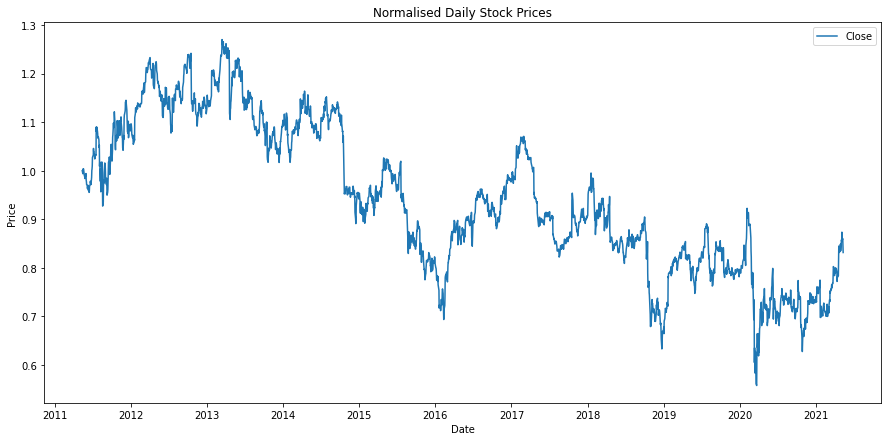

In [30]:
## Plot the Normalised Daily Stock Prices

plt.figure(figsize=[15,7])
plt.plot(norm_stock_price)
plt.title('Normalised Daily Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(norm_stock_price)
plt.show()

Stock Price Dispersion from Mean - Visualization

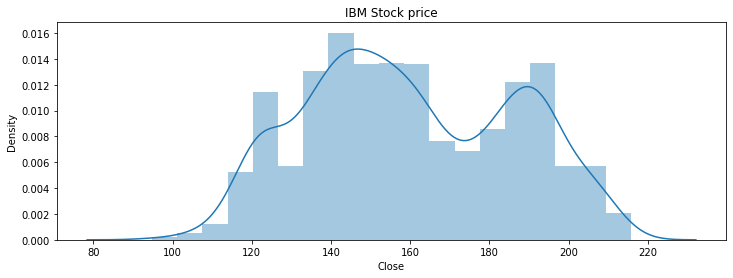

In [31]:
# Plot the distribution plot of different stocks

plt.figure(figsize=[12,4])
sns.distplot(stock_price['Close'])
plt.title('IBM Stock price')
plt.show()

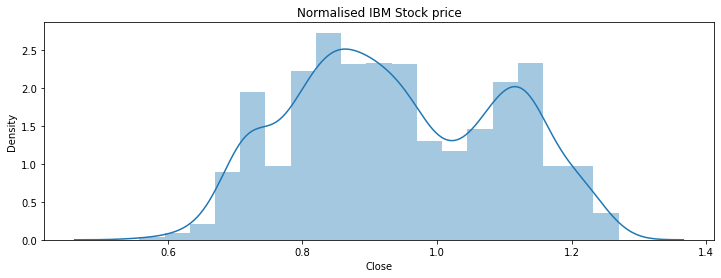

In [32]:
# Plot the distribution plot of different stocks

plt.figure(figsize=[12,4])
sns.distplot(norm_stock_price['Close'])
plt.title('Normalised IBM Stock price')
plt.show()

In [33]:
# Daily Returns

returns = stock_price.pct_change()
returns.head()

,Close
Date,
2011-05-13,NaN
2011-05-16,-0.006238
2011-05-17,0.009712
2011-05-18,-0.000352
2011-05-19,0.000880


In [34]:
# Dropping the rows with missing values

returns = returns.dropna(axis=0)

In [35]:
## Check the shape of the dataframe

returns.shape

(2515, 1)

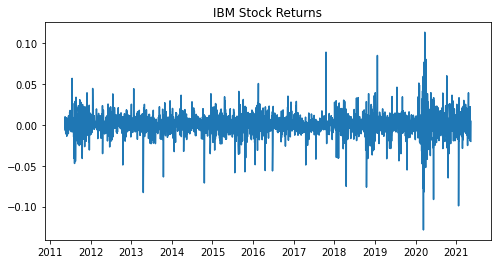

In [36]:
## Plot for Market Index S&P500 Returns

plt.figure(figsize=[8,4])
plt.plot(returns['Close'])
plt.title('IBM Stock Returns')
plt.show()

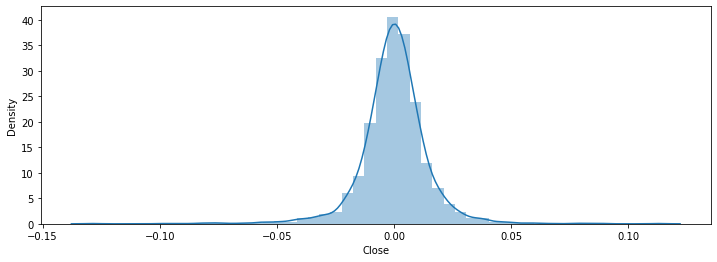

In [37]:
# Plot the distribution plot of Daily Returns

plt.figure(figsize=[12,4])
sns.distplot(returns['Close'])
plt.show()

In [38]:
# Average daily return of stock

returns_mean = returns.mean()
returns_mean

Close    0.000034
dtype: float64

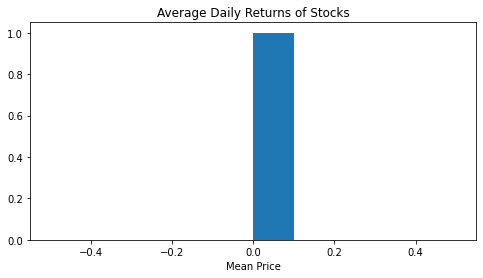

In [39]:
# Average Daily Returns Plot

plt.figure(figsize=[8,4])
plt.hist(returns_mean)
plt.xlabel('Mean Price')
plt.title('Average Daily Returns of Stocks')
plt.show()

In [40]:
## Annualised Returns

ann_returns = 252*returns_mean
ann_returns

Close    0.008648
dtype: float64

In [41]:
# Annualized Returns in Percent

ann_returns_pct = ann_returns*100
ann_returns_pct

Close    0.864758
dtype: float64

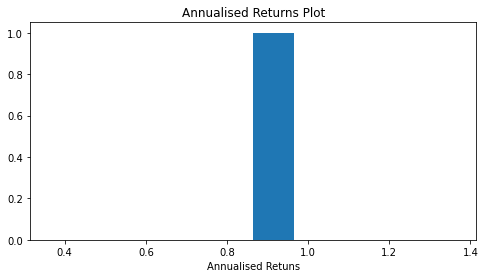

In [42]:
# Annualised Returns Plot in Percent

plt.figure(figsize=[8,4])
plt.hist(ann_returns_pct)
plt.xlabel('Annualised Retuns')
plt.title('Annualised Returns Plot')
plt.show()

Statistical Summary of Daily Returns

In [43]:
## Describe the Daily Returns

returns.describe()

,Close
count,2515.000000
mean,0.000034
std,0.014631
min,-0.128507
25%,-0.006426
50%,0.000228
75%,0.006959
max,0.113010


Risk/Volatility of Stock - Standard Deviation

In [44]:
## Risk associated with Stock 

risk = returns.std()
risk

Close    0.014631
dtype: float64

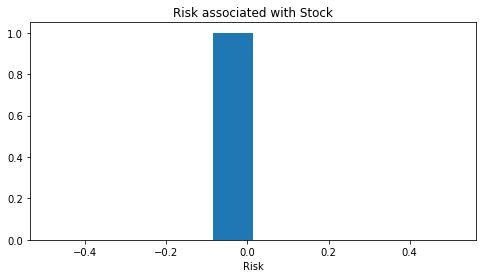

In [45]:
# Plot for Risk associated with Stock

plt.figure(figsize=[8,4])
plt.hist(risk)
plt.xlabel('Risk')
plt.title('Risk associated with Stock')
plt.show()

In [46]:
## Annualised Risk - Calculated using No of Trading Days which is 252

ann_risk = np.sqrt(252)*risk
ann_risk

Close    0.232264
dtype: float64

In [47]:
# Annualized Risk in Percent

ann_risk_pct = ann_risk*100
ann_risk_pct

Close    23.226371
dtype: float64

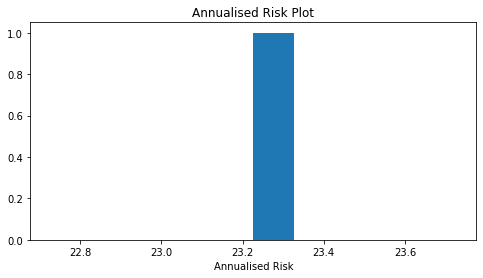

In [48]:
# Annualised Risk Plot in Percent

plt.figure(figsize=[8,4])
plt.hist(ann_risk_pct)
plt.xlabel('Annualised Risk')
plt.title('Annualised Risk Plot')
plt.show()

  Cumulative Daily Returns

In [49]:
## Fetch the Last Row of Returns

stock_price.iloc[-1]

Close    141.3
Name: 2021-05-12 00:00:00, dtype: float64

In [50]:
## Fetch the First Row of Returns

stock_price.iloc[0]

Close    169.92
Name: 2011-05-13 00:00:00, dtype: float64

In [51]:
# Cumulative returns from the portfolio

cum_returns = stock_price[-1:]/np.array(stock_price[:1]) - 1
cum_returns

,Close
Date,
2021-05-12,-0.168432


In [52]:
# Cumulative Returns in Percent

cum_returns_pct = cum_returns*100
cum_returns_pct

,Close
Date,
2021-05-12,-16.84322


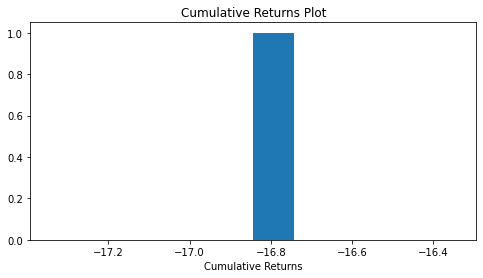

In [53]:
# Cumulative Returns Plot in Percent

plt.figure(figsize=[8,4])
plt.hist(cum_returns_pct)
plt.xlabel('Cumulative Returns')
plt.title('Cumulative Returns Plot')
plt.show()

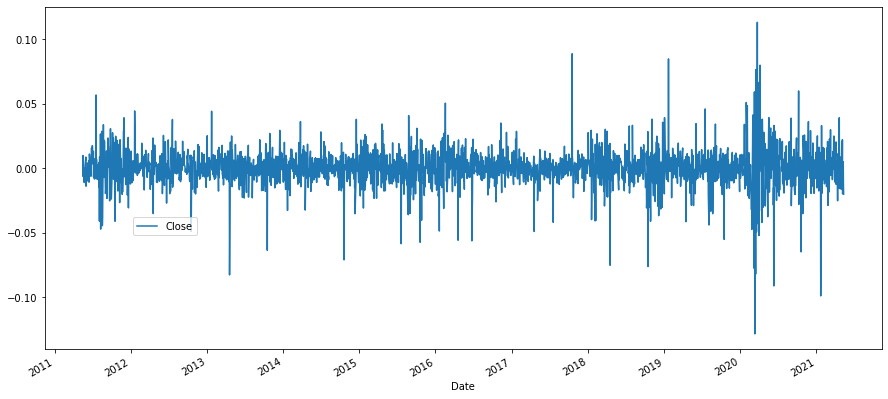

In [54]:
#Plot the Distribution of Daily Returns of the stocks 

returns.plot(figsize=(15,7))
plt.legend(returns, loc='upper left', bbox_to_anchor=(0.1, 0.4), ncol=3)
plt.show()

### **Step 3: Model Building, Training and Testing**

### **Model 1 - LSTM**

In [55]:
## Function to plot the time series data

def historical_plot(df):
  plt.figure(figsize=(14,14))
  plt.plot(df['Close'])
  plt.title('Historical Stock Value')
  plt.xlabel('Date')
  plt.ylabel('Stock Price')
  plt.show()

In [56]:
## Function to Split Traing and test data for LSTM

def lstm_datapreproc(df, split_date):
  df_train = df[:split_date]
  df_test = df[split_date:]
  print('Shape of train is ' + str(df_train.shape)) 
  print('Shape of test is ' + str(df_test.shape))
  sc = MinMaxScaler(feature_range = (0, 1))
  train_set = df_train[['Close']].values
  training_set_scaled = sc.fit_transform(train_set)
  list_training_set_scaled = training_set_scaled.tolist()
  X_train = []
  y_train = []
  for i in range(60, len(df_train)-1):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0]) 
  X_train, y_train = np.array(X_train), np.array(y_train)
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
  return df_train, df_test, X_train, y_train, sc, list_training_set_scaled

In [57]:
## Splitting training and test data

df_train, df_test, X_train, y_train, sc, list_training_set_scaled = lstm_datapreproc(df, '2020-01-01')

Shape of train is (2173, 5)
Shape of test is (343, 5)


In [58]:
## Function to train LSTM model

def lstm_nnmodel(X_train,y_train,epochs, units, num_layers):
  regressor = Sequential()
  regressor.add(LSTM(units = units, return_sequences = True, input_shape = (X_train.shape[1], 1)))
  regressor.add(Dropout(0.2))
  for i in range(num_layers):
    regressor.add(LSTM(units = units, return_sequences = True))
    regressor.add(Dropout(0.2))
  regressor.add(LSTM(units = units))
  regressor.add(Dropout(0.2))
  regressor.add(Dense(units = 1))
  regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_absolute_error'])
  regressor.fit(X_train, y_train, epochs = epochs, batch_size = 32)
  return regressor

In [59]:
## Training LSTM Model

regressor = lstm_nnmodel(X_train,y_train, epochs=2, units=200, num_layers=2)

Epoch 1/2
66/66 [==============================] - 30s 381ms/step - loss: 0.0218 - mean_absolute_error: 0.1000
Epoch 2/2
66/66 [==============================] - 25s 379ms/step - loss: 0.0042 - mean_absolute_error: 0.0492


In [60]:
## Function to validate LSTM Model using test dataset

def lsmt_test_dataset(df, df_test,sc, regressor ):
  real_stock_price = df_test.iloc[:, 3:4].values
  dataset_total = df['Close']
  inputs = dataset_total[len(dataset_total) - len(df_test) - 60:].values
  inputs = inputs.reshape(-1,1)
  inputs = sc.transform(inputs)
  X_test = []
  for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
  predicted_stock_price = regressor.predict(X_test)
  predicted_stock_price = sc.inverse_transform(predicted_stock_price)
  return real_stock_price , X_test, predicted_stock_price

In [61]:
## Test/Validate the Model using test dataset

real_stock_price , X_test, predicted_stock_price = lsmt_test_dataset(df, df_test, sc, regressor)

11/11 [==============================] - 2s 116ms/step


In [62]:
## Creating a dataframe with Real and Predicted Stock Price

df_lstm = pd.DataFrame(real_stock_price, index=df_test.index, columns=['real_stock_price'])
df_lstm['predicted_stock_price'] = predicted_stock_price

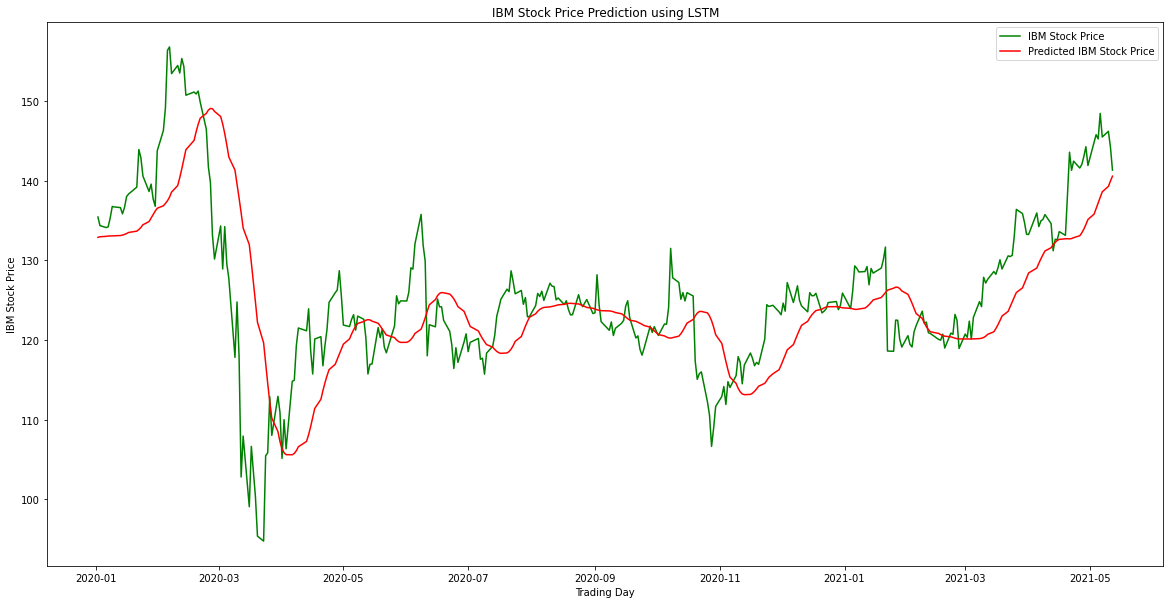

In [63]:
## Plot the LSTM Model with Real and Predicted Price

plt.figure(figsize=(20,10))
plt.plot(df_lstm['real_stock_price'], color = 'green', label = 'IBM Stock Price')
plt.plot(df_lstm['predicted_stock_price'], color = 'red', label = 'Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction using LSTM')
plt.xlabel('Trading Day')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()

In [64]:
## Calculate RMSE of LSTM Model

rmse_lstm = np.sqrt(np.mean((df_lstm['real_stock_price']-df_lstm['predicted_stock_price'])**2))
rmse_lstm

7.685129552893544

In [65]:
##Calculate MAPE of LSTM Model

mape_lstm = np.mean(np.abs((df_lstm['real_stock_price']-df_lstm['predicted_stock_price']) / df_lstm['real_stock_price']))*100
mape_lstm

4.43866180337923

In [66]:
## Create a dataframe with store te real and predicted price of all models

df_price_ensemble = pd.DataFrame(df_lstm, index=df_lstm.index)
df_price_ensemble.columns=['Actual_Price', 'Predicted_Price_LSTM']
df_price_ensemble.head()

,Actual_Price,Predicted_Price_LSTM
Date,,
2020-01-02,135.42,132.869736
2020-01-03,134.34,132.943710
2020-01-06,134.10,132.998108
2020-01-07,134.19,133.033157
2020-01-08,135.31,133.049911


### **Model 2 -CNN**

In [67]:
## Function to Split data for training

def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [68]:
# define input sequence
# raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# list_training_set_scaled
# choose a number of time steps
n_steps_in, n_steps_out = 1000, 343
# split into samples
X, y = split_sequence(list_training_set_scaled, n_steps_in, n_steps_out)

In [69]:
# reshape from [samples, timesteps] into [samples, timesteps, features]

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [70]:
# Define Model

model = Sequential()
#model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(Conv1D(filters=64, kernel_size=2, strides=1, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2, strides=1))
model.add(Conv1D(filters=32, kernel_size=2, strides=1, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2, strides=1))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [71]:
# Fit the Model

model.fit(X, y, epochs=150, batch_size=64)

# demonstrate prediction
# x_input = array([70, 80, 90])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

Epoch 1/150
13/13 [==============================] - 2s 123ms/step - loss: 0.1114
Epoch 2/150
13/13 [==============================] - 2s 125ms/step - loss: 0.0333
Epoch 3/150
13/13 [==============================] - 2s 122ms/step - loss: 0.0145
Epoch 4/150
13/13 [==============================] - 2s 122ms/step - loss: 0.0115
Epoch 5/150
13/13 [==============================] - 2s 124ms/step - loss: 0.0107
Epoch 6/150
13/13 [==============================] - 2s 121ms/step - loss: 0.0104
Epoch 7/150
13/13 [==============================] - 2s 123ms/step - loss: 0.0102
Epoch 8/150
13/13 [==============================] - 2s 121ms/step - loss: 0.0100
Epoch 9/150
13/13 [==============================] - 2s 122ms/step - loss: 0.0098
Epoch 10/150
13/13 [==============================] - 2s 122ms/step - loss: 0.0095
Epoch 11/150
13/13 [==============================] - 2s 119ms/step - loss: 0.0092
Epoch 12/150
13/13 [==============================] - 2s 123ms/step - loss: 0.0087
Epoch 13/150


In [72]:
## Scaling the test dataset

df_train_lst_500 = df_train.tail(1000)
test_set=df_train_lst_500.iloc[:,3:4].values
testing_set_scaled = sc.fit_transform(test_set)

# train_set = df_train.iloc[:, 0:1].values
# training_set_scaled = sc.fit_transform(train_set)

In [73]:
## Reshape the test set

x_input = testing_set_scaled.reshape((1, n_steps_in, n_features))

In [74]:
## Test the Model

yhat = model.predict(x_input, verbose=0)

In [75]:
## Reshape the yhat data

print(yhat.shape)
X_test = np.reshape(yhat, (343, 1))

(1, 343)


In [76]:
## Get the predicted Stock Price

predicted_stock_price = sc.inverse_transform(X_test)

In [77]:
## Get the Real Stock Price

real_stock_price = df_test.iloc[:, 3:4].values

In [78]:
## Store the Real & Predicted data into a dataframe

df_cnn = pd.DataFrame(real_stock_price, index=df_test.index, columns=['real_stock_price'])
df_cnn['predicted_stock_price'] = predicted_stock_price
df_cnn.head()

,real_stock_price,predicted_stock_price
Date,,
2020-01-02,135.42,132.283905
2020-01-03,134.34,132.109100
2020-01-06,134.10,132.158890
2020-01-07,134.19,131.789764
2020-01-08,135.31,126.761040


In [79]:
## print the last few rows

df_cnn.tail()

,real_stock_price,predicted_stock_price
Date,,
2021-05-06,148.42,127.951942
2021-05-07,145.46,129.770920
2021-05-10,146.17,127.879669
2021-05-11,144.22,128.641724
2021-05-12,141.30,125.902168


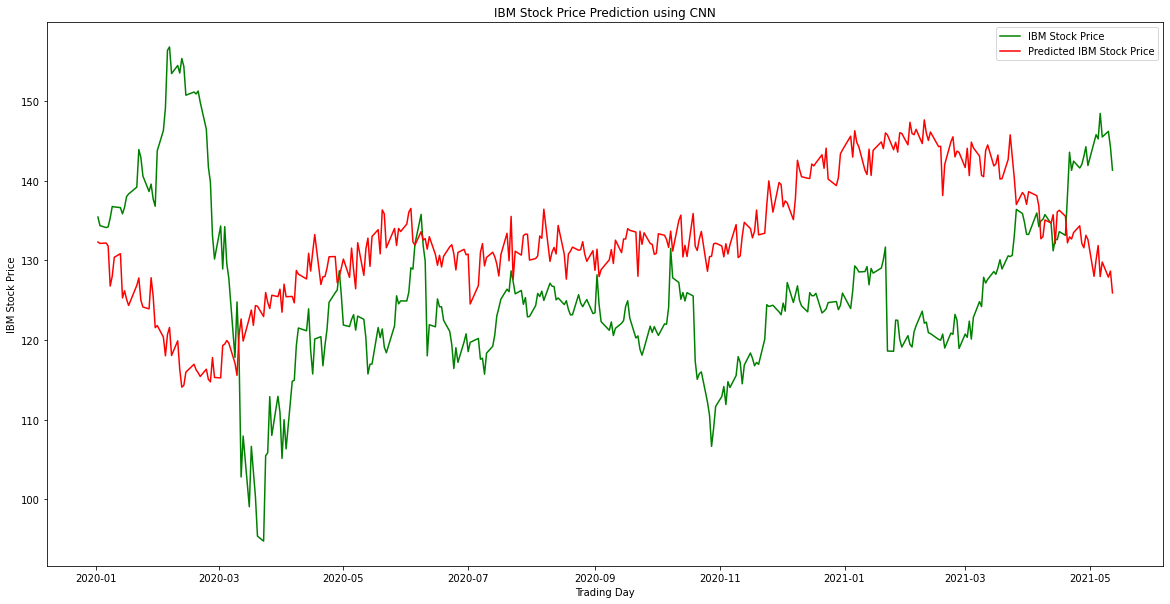

In [80]:
## Plot the Real and Predicted Stock Price

plt.figure(figsize=(20,10))
plt.plot(df_cnn['real_stock_price'], color = 'green', label = 'IBM Stock Price')
plt.plot(df_cnn['predicted_stock_price'], color = 'red', label = 'Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction using CNN')
plt.xlabel('Trading Day')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()

In [81]:
## Calculate the RMSE of CNN Model

rmse_cnn = np.sqrt(np.mean((df_cnn['real_stock_price']-df_cnn['predicted_stock_price'])**2))
rmse_cnn

15.434901040718918

In [82]:
## Calculate the MAPE of CNN Model
  
mape_cnn = np.mean(np.abs((df_cnn['real_stock_price']-df_cnn['predicted_stock_price']) / df_cnn['real_stock_price']))*100
mape_cnn

10.60175647631922

In [83]:
## Adding the predicted price from CNN Model into Ensemble dataframe

df_price_ensemble['Predicted_Price_CNN'] = df_cnn['predicted_stock_price']

In [84]:
## Print the first few rows

df_price_ensemble.head()

,Actual_Price,Predicted_Price_LSTM,Predicted_Price_CNN
Date,,,
2020-01-02,135.42,132.869736,132.283905
2020-01-03,134.34,132.943710,132.109100
2020-01-06,134.10,132.998108,132.158890
2020-01-07,134.19,133.033157,131.789764
2020-01-08,135.31,133.049911,126.761040


### **Model 3 - GAN**

In [85]:
# Calculate technical indicators

def get_technical_indicators(data):
    # Create 7 and 21 days Moving Average
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean()
    data['MA21'] = data.iloc[:,4].rolling(window=21).mean()

    # Create MACD
    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA21'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA21'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data
T_df = get_technical_indicators(df)

In [86]:
#Drop the first 21 rows
#For doing the fourier

#dataset = T_df.iloc[20:,:].reset_index(drop=True)
dataset = T_df.iloc[20:,:].reset_index()
T_df.reset_index(inplace=True)

In [87]:
#Getting the Fourier transform features

def get_fourier_transfer(dataset):
    # Get the columns for doing fourier
    data_FT = dataset[['Date', 'Close']]

    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    fft_df = pd.DataFrame({'fft': close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

    fft_list = np.asarray(fft_df['fft'].tolist())
    fft_com_df = pd.DataFrame()
    for num_ in [3, 6, 9]:
        fft_list_m10 = np.copy(fft_list);
        fft_list_m10[num_:-num_] = 0
        fft_ = np.fft.ifft(fft_list_m10)
        fft_com = pd.DataFrame({'fft': fft_})
        fft_com['absolute of ' + str(num_) + ' comp'] = fft_com['fft'].apply(lambda x: np.abs(x))
        fft_com['angle of ' + str(num_) + ' comp'] = fft_com['fft'].apply(lambda x: np.angle(x))
        fft_com = fft_com.drop(columns='fft')
        fft_com_df = pd.concat([fft_com_df, fft_com], axis=1)

    return fft_com_df

#Get Fourier features
dataset_F = get_fourier_transfer(dataset)
Final_data = pd.concat([dataset, dataset_F], axis=1)

In [88]:
## Print first few rows of Final Data 

Final_data.head()

,Date,Open,High,Low,Close,Volume,MA7,MA21,MACD,20SD,upper_band,lower_band,EMA,logmomentum,absolute of 3 comp,angle of 3 comp,absolute of 6 comp,angle of 6 comp,absolute of 9 comp,angle of 9 comp
0,2011-06-13,164.44,164.46,162.73,163.17,5099508,4.425155e+06,4.905880e+06,4.778237e+06,1.539434e+06,7.984748e+06,1.827013e+06,4.905939e+06,15.444654,154.464342,0.007245,150.852378,0.016044,149.322846,-0.003242
1,2011-06-14,163.87,164.57,163.65,164.12,7050074,4.685094e+06,4.995455e+06,4.984438e+06,1.611533e+06,8.218521e+06,1.772389e+06,6.335362e+06,15.768549,154.630930,0.007258,151.169780,0.015926,149.702543,-0.003183
2,2011-06-15,162.75,163.41,161.52,162.33,5225995,4.914568e+06,5.022266e+06,5.005989e+06,1.346554e+06,7.715374e+06,2.329158e+06,5.595784e+06,15.469156,154.797701,0.007271,151.487586,0.015805,150.083653,-0.003123
3,2011-06-16,162.06,163.63,161.78,162.67,4861065,5.010506e+06,4.834989e+06,4.993230e+06,1.337108e+06,7.509204e+06,2.160773e+06,5.105971e+06,15.396768,154.964653,0.007284,151.805775,0.015681,150.466133,-0.003061
4,2011-06-17,164.24,165.10,163.58,164.44,7153383,5.482313e+06,4.977664e+06,5.180587e+06,1.391128e+06,7.759921e+06,2.195408e+06,6.470912e+06,15.783096,155.131782,0.007296,152.124321,0.015554,150.849940,-0.002998


In [89]:
## Create a csv file with Fourier transformation

Final_data.to_csv("Finaldata_with_Fourier.csv", index=False)

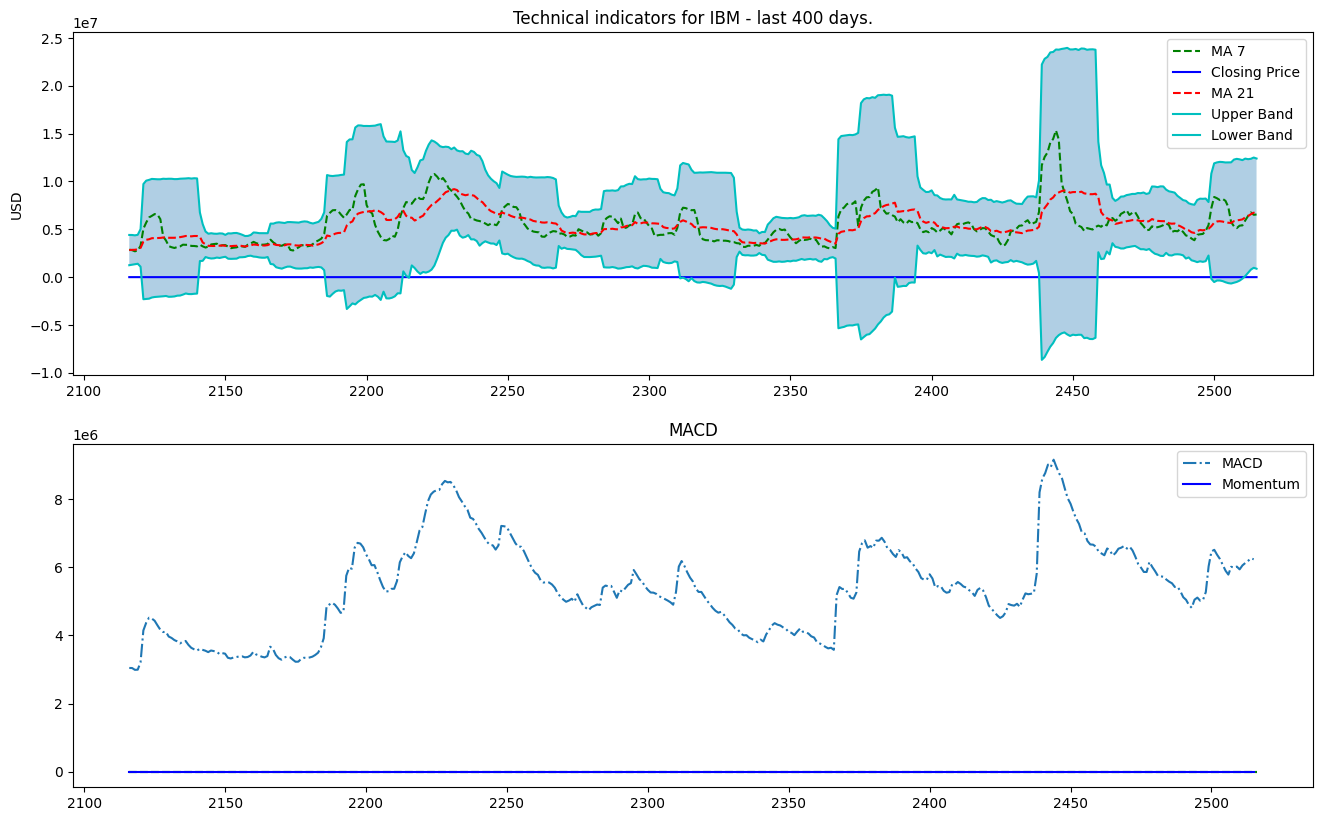

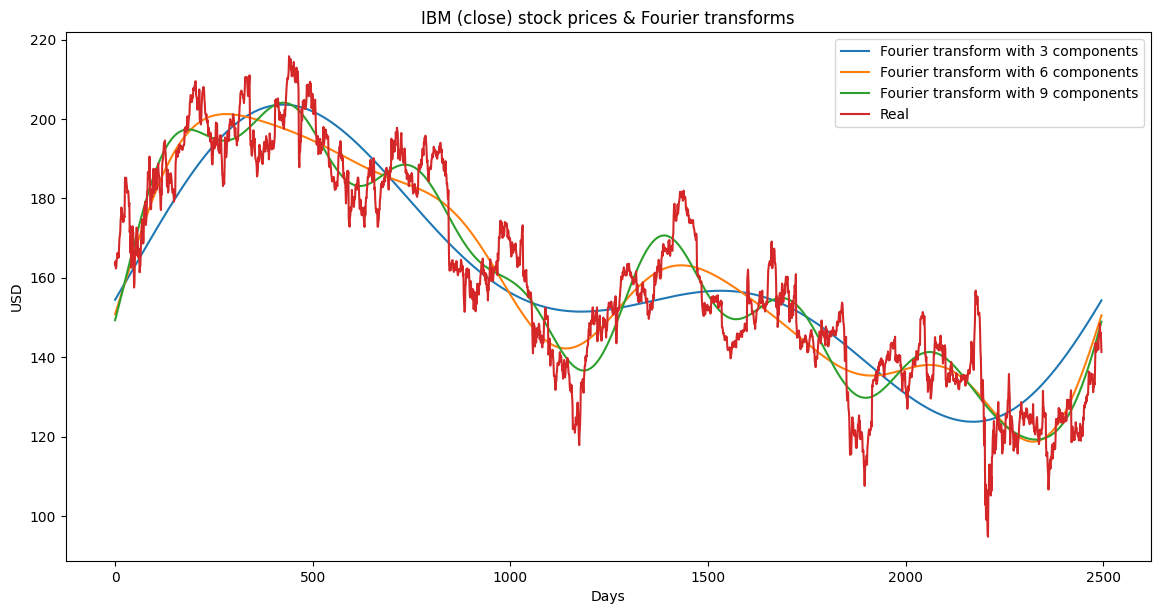

In [90]:
## Function to plot Technical indicators and Fourier Transformation

def plot_technical_indicators(dataset, last_days):
       plt.figure(figsize=(16, 10), dpi=100)
       shape_0 = dataset.shape[0]
       xmacd_ = shape_0 - last_days

       dataset = dataset.iloc[-last_days:, :]
       x_ = range(3, dataset.shape[0])
       x_ = list(dataset.index)

       # Plot first subplot
       plt.subplot(2, 1, 1)
       plt.plot(dataset['MA7'], label='MA 7', color='g', linestyle='--')
       plt.plot(dataset['Close'], label='Closing Price', color='b')
       plt.plot(dataset['MA21'], label='MA 21', color='r', linestyle='--')
       plt.plot(dataset['upper_band'], label='Upper Band', color='c')
       plt.plot(dataset['lower_band'], label='Lower Band', color='c')
       plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
       plt.title('Technical indicators for IBM - last {} days.'.format(last_days))
       plt.ylabel('USD')
       plt.legend()

       # Plot second subplot
       plt.subplot(2, 1, 2)
       plt.title('MACD')
       plt.plot(dataset['MACD'], label='MACD', linestyle='-.')
       plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
       plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
       plt.plot(dataset['logmomentum'], label='Momentum', color='b', linestyle='-')
       
       plt.legend()
       plt.show()

plot_technical_indicators(T_df, 400)


def plot_Fourier(dataset):
    data_FT = dataset[['Date', 'Close']]
    
    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    fft_df = pd.DataFrame({'fft': close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

    fft_list = np.asarray(fft_df['fft'].tolist())
    plt.figure(figsize=(14, 7), dpi=100)
    fft_list = np.asarray(fft_df['fft'].tolist())
    for num_ in [3, 6, 9]:
        fft_list_m10 = np.copy(fft_list);
        fft_list_m10[num_:-num_] = 0
        plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
    plt.plot(data_FT['Close'], label='Real')
    plt.xlabel('Days')
    plt.ylabel('USD')
    plt.title('IBM (close) stock prices & Fourier transforms')
    plt.legend()
    plt.show()

plot_Fourier(dataset)

In [91]:
## Load Data for GAN

dataset = pd.read_csv('Finaldata_with_Fourier.csv', parse_dates=['Date'])

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'MA7', 'MA21', 'MACD',
       '20SD', 'upper_band', 'lower_band', 'EMA', 'logmomentum',
       'absolute of 3 comp', 'angle of 3 comp', 'absolute of 6 comp',
       'angle of 6 comp', 'absolute of 9 comp', 'angle of 9 comp'],
      dtype='object')


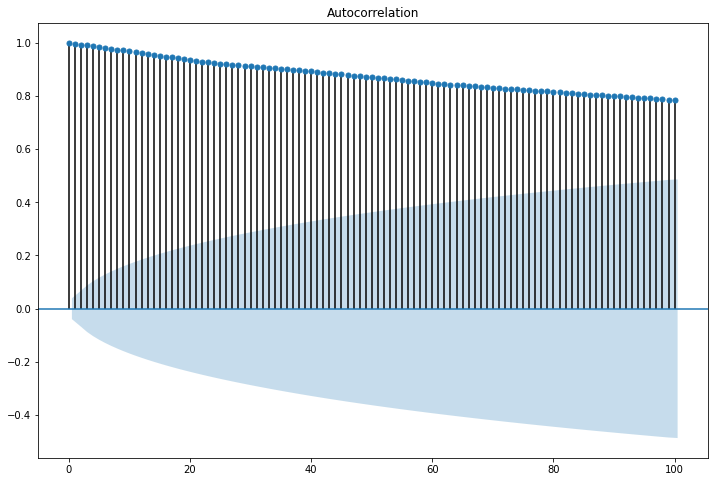

In [92]:
## Data Preprocessing for GAN

# Replace 0 by NA
dataset.replace(0, np.nan, inplace=True)
dataset.to_csv("dataset.csv", index=False)

# Add News data
#dataset["News"] = news["Score"]

# Check NA and fill them
dataset.isnull().sum()
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill(), dataset.iloc[:, 1:].bfill()]).groupby(level=0).mean()
print(dataset.columns)

# Set the date to datetime data
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')

# Get features and target
X_value = pd.DataFrame(dataset.iloc[:, :])
y_value = pd.DataFrame(dataset.iloc[:, 3])

# Autocorrelation Check
sm.graphics.tsa.plot_acf(y_value.squeeze(), lags=100)
plt.show()

# Normalized the data
X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaler.fit(X_value)
y_scaler.fit(y_value)

X_scale_dataset = X_scaler.fit_transform(X_value)
y_scale_dataset = y_scaler.fit_transform(y_value)

dump(X_scaler, open('X_scaler.pkl', 'wb'))
dump(y_scaler, open('y_scaler.pkl', 'wb'))

# Reshape the data
'''Set the data input steps and output steps, 
    we use 30 days data to predict 1 day price here, 
    reshape it to (None, input_step, number of features) used for LSTM input'''
n_steps_in = 3
n_features = X_value.shape[1]
n_steps_out = 1

# Get X/y dataset
def get_X_y(X_data, y_data):
    X = list()
    y = list()
    yc = list()

    length = len(X_data)
    for i in range(0, length, 1):
        X_value = X_data[i: i + n_steps_in][:, :]
        y_value = y_data[i + n_steps_in: i + (n_steps_in + n_steps_out)][:, 0]
        yc_value = y_data[i: i + n_steps_in][:, :]
        if len(X_value) == 3 and len(y_value) == 1:
            X.append(X_value)
            y.append(y_value)
            yc.append(yc_value)

    return np.array(X), np.array(y), np.array(yc)

# get the train test predict index
def predict_index(dataset, X_train, n_steps_in, n_steps_out):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[n_steps_in : X_train.shape[0] + n_steps_in + n_steps_out - 1, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + n_steps_in:, :].index

    return train_predict_index, test_predict_index

# Split train/test dataset
def split_train_test(data):
    #train_size = round(len(X) * 0.7)
    train_size= 2150
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

# Get data and check shape
X, y, yc = get_X_y(X_scale_dataset, y_scale_dataset)
X_train, X_test, = split_train_test(X)
y_train, y_test, = split_train_test(y)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, n_steps_in, n_steps_out)

In [93]:
## Print the shape of train and test datasets

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(yc_train.shape)
print(yc_test.shape)

(2150, 3, 19)
(343, 3, 19)
(2150, 1)
(343, 1)
(2150, 3, 1)
(343, 3, 1)


In [94]:
## Save the datasets 

print('X shape: ', X.shape)
print('y shape: ', y.shape)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('y_c_train shape: ', yc_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)
print('y_c_test shape: ', yc_test.shape)
print('index_train shape:', index_train.shape)
print('index_test shape:', index_test.shape)

np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)
np.save("yc_train.npy", yc_train)
np.save("yc_test.npy", yc_test)
np.save('index_train.npy', index_train)
np.save('index_test.npy', index_test)

X shape:  (2493, 3, 19)
y shape:  (2493, 1)
X_train shape:  (2150, 3, 19)
y_train shape:  (2150, 1)
y_c_train shape:  (2150, 3, 1)
X_test shape:  (343, 3, 19)
y_test shape:  (343, 1)
y_c_test shape:  (343, 3, 1)
index_train shape: (2150,)
index_test shape: (343,)


In [95]:
## Load the datasets

X_train = np.load("X_train.npy", allow_pickle=True)
y_train = np.load("y_train.npy", allow_pickle=True)
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)
yc_train = np.load("yc_train.npy", allow_pickle=True)
yc_test = np.load("yc_test.npy", allow_pickle=True)

In [96]:
## Create Functions for Generator Model using GRU and Discriminator Model using CNN

## Generator Model
def make_generator_model(input_dim, output_dim, feature_size) -> tf.keras.models.Model:

    model = Sequential()
    model.add(GRU(units=1024, return_sequences = True, input_shape=(input_dim, feature_size),
                  recurrent_dropout=0.2))
    model.add(GRU(units=512, return_sequences = True, recurrent_dropout=0.2)) # 256, return_sequences = True
    model.add(GRU(units=256, recurrent_dropout=0.2)) #, recurrent_dropout=0.1
    # , recurrent_dropout = 0.2
    model.add(Dense(128))
    # model.add(Dense(128))
    model.add(Dense(64))
    #model.add(Dense(16))
    model.add(Dense(units=output_dim))
    return model

## Discriminator Model
def make_discriminator_model():

    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(32, input_shape=(4, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Flatten())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

In [97]:
## Print the Dicriminator Model Summary

model = make_discriminator_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 2, 32)             128       
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 64)             10304     
                                                                 
 conv1d_4 (Conv1D)           (None, 1, 128)            41088     
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 220)               28160     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 220)               0         
                                                                 
 dense_4 (Dense)             (None, 220)              

In [98]:
## Class and Function for Generator and Discriminator Loss Function

class GAN:
    def __init__(self, generator, discriminator, opt):
        self.opt = opt
        self.lr = opt["lr"]
        self.generator = generator
        self.discriminator = discriminator
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.generator_optimizer = tf.keras.optimizers.Adam(lr=self.lr)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(lr=self.lr)
        self.batch_size = self.opt['bs']
        self.checkpoint_dir = '../training_checkpoints'
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                              discriminator_optimizer=self.discriminator_optimizer,
                                              generator=self.generator,
                                              discriminator=self.discriminator)

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    @tf.function
    def train_step(self, real_x, real_y, yc):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_data = self.generator(real_x, training=True)
            generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
            d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
            real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
            d_real_input = tf.concat([real_y_reshape, yc], axis=1)

            # Reshape for MLP
            # d_fake_input = tf.reshape(d_fake_input, [d_fake_input.shape[0], d_fake_input.shape[1]])
            # d_real_input = tf.reshape(d_real_input, [d_real_input.shape[0], d_real_input.shape[1]])

            real_output = self.discriminator(d_real_input, training=True)
            fake_output = self.discriminator(d_fake_input, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(
            zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': gen_loss}

    def train(self, real_x, real_y, yc, opt):
        train_hist = {}
        train_hist['D_losses'] = []
        train_hist['G_losses'] = []
        train_hist['per_epoch_times'] = []
        train_hist['total_ptime'] = []

        epochs = opt["epoch"]
        for epoch in range(epochs):
            start = time.time()

            real_price, fake_price, loss = self.train_step(real_x, real_y, yc)

            G_losses = []
            D_losses = []

            Real_price = []
            Predicted_price = []

            D_losses.append(loss['d_loss'].numpy())
            G_losses.append(loss['g_loss'].numpy())

            Predicted_price.append(fake_price.numpy())
            Real_price.append(real_price.numpy())

            # Save the model every 15 epochs
            if (epoch + 1) % 15 == 0:
                tf.keras.models.save_model(generator, 'gen_model_3_1_%d.h5' % epoch)
                self.checkpoint.save(file_prefix=self.checkpoint_prefix + f'-{epoch}')
                print('epoch', epoch + 1, 'd_loss', loss['d_loss'].numpy(), 'g_loss', loss['g_loss'].numpy())
            # print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
            # For printing loss
            epoch_end_time = time.time()
            per_epoch_ptime = epoch_end_time - start
            train_hist['D_losses'].append(D_losses)
            train_hist['G_losses'].append(G_losses)
            train_hist['per_epoch_times'].append(per_epoch_ptime)

        # Reshape the predicted result & real
        Predicted_price = np.array(Predicted_price)
        Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
        Real_price = np.array(Real_price)
        Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

        plt.plot(train_hist['D_losses'], label='D_loss')
        plt.plot(train_hist['G_losses'], label='G_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

epoch 15 d_loss 1.3866849 g_loss 0.69356585


epoch 30 d_loss 1.3871024 g_loss 0.6909038


epoch 45 d_loss 1.3860562 g_loss 0.69561946


epoch 60 d_loss 1.3862721 g_loss 0.6951281


epoch 75 d_loss 1.3864839 g_loss 0.694194


epoch 90 d_loss 1.3864353 g_loss 0.6936125


epoch 105 d_loss 1.386396 g_loss 0.6934593


epoch 120 d_loss 1.3863434 g_loss 0.6930567


epoch 135 d_loss 1.3861976 g_loss 0.6930027


epoch 150 d_loss 1.3863679 g_loss 0.6931669


epoch 165 d_loss 1.3863335 g_loss 0.69263625


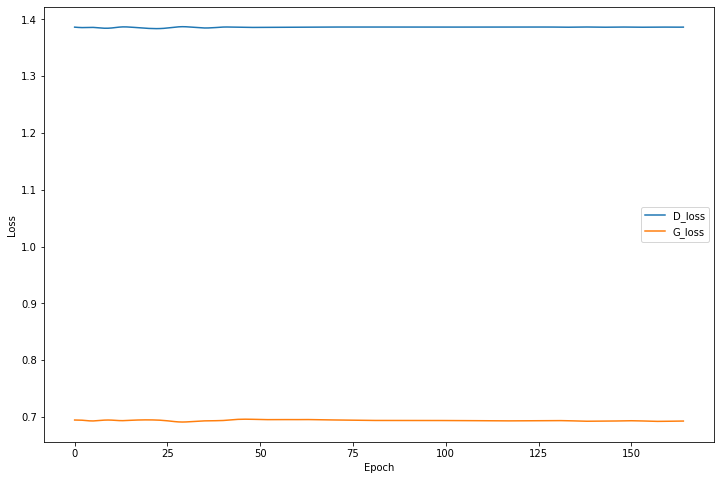

In [99]:
## Main Function to call Generator and Discriminator

if __name__ == '__main__':
    input_dim = X_train.shape[1]
    feature_size = X_train.shape[2]
    output_dim = y_train.shape[1]

    ## For Bayesian
    opt = {"lr": 0.00016, "epoch": 165, 'bs': 128}

    generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
    discriminator = make_discriminator_model()
    gan = GAN(generator, discriminator, opt)
    Predicted_price, Real_price, RMSPE = gan.train(X_train, y_train, yc_train, opt)

----- predicted price ----- [[ 0.15207127]
 [ 0.14088802]
 [ 0.13718836]
 ...
 [-0.35127595]
 [-0.3558011 ]
 [-0.36600026]]
----- rescaled predicted price ----- [[164.48758]
 [163.81085]
 [163.58696]
 ...
 [134.02753]
 [133.7537 ]
 [133.13649]]
----- SHAPE rescaled predicted price ----- (2150, 1)


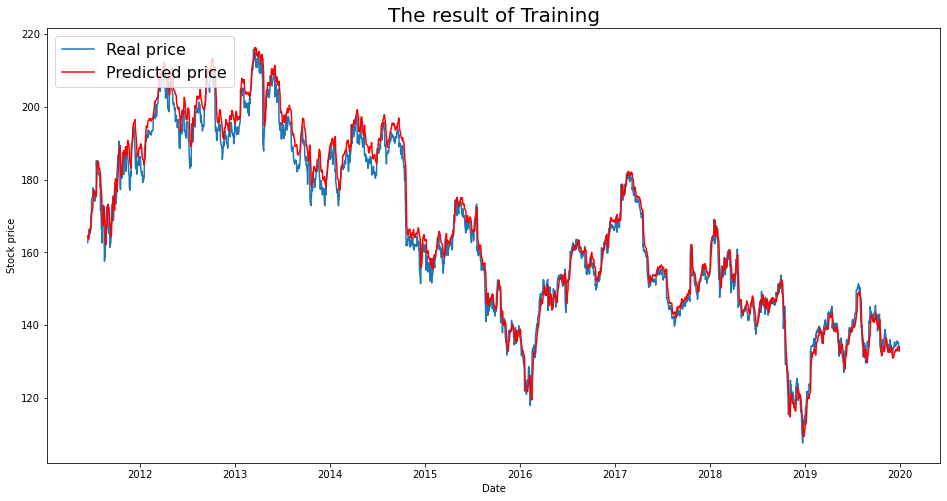

-- Train RMSE --  3.685578647929124


In [100]:
## Plot the results

# Rescale back the real dataset
X_scaler = load(open('X_scaler.pkl', 'rb'))
y_scaler = load(open('y_scaler.pkl', 'rb'))

# train_predict_index = np.load("train_predict_index.npy", allow_pickle=True)
# test_predict_index = np.load("test_predict_index.npy", allow_pickle=True)
#dataset_train = pd.read_csv('dataset_train.csv', index_col=0)'
train_predict_index = np.load("index_train.npy", allow_pickle=True)
test_predict_index = np.load("index_test.npy", allow_pickle=True)


print("----- predicted price -----", Predicted_price)

rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

print("----- rescaled predicted price -----", rescaled_Predicted_price)
print("----- SHAPE rescaled predicted price -----", rescaled_Predicted_price.shape)

predict_result = pd.DataFrame()
for i in range(rescaled_Predicted_price.shape[0]):
    y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
#
real_price = pd.DataFrame()
for i in range(rescaled_Real_price.shape[0]):
    y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
    real_price = pd.concat([real_price, y_train], axis=1, sort=False)

predict_result['predicted_mean'] = predict_result.mean(axis=1)
real_price['real_mean'] = real_price.mean(axis=1)

# Plot the predicted result
plt.figure(figsize=(16, 8))
plt.plot(real_price["real_mean"])
plt.plot(predict_result["predicted_mean"], color = 'r')
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
plt.title("The result of Training", fontsize=20)
plt.show()

# Calculate RMSE
predicted = predict_result["predicted_mean"]
real = real_price["real_mean"]
For_MSE = pd.concat([predicted, real], axis = 1)
RMSE = np.sqrt(mean_squared_error(predicted, real))
print('-- Train RMSE -- ', RMSE)

In [101]:
## Print First few rows of Predicted Results Mean

predict_result['predicted_mean'].head()

2011-06-16    164.487579
2011-06-17    163.810852
2011-06-20    163.586960
2011-06-21    164.275101
2011-06-22    165.343658
Name: predicted_mean, dtype: float32

In [102]:
## Print First few rows of Real Price Mean

real_price['real_mean'].head()

2011-06-16    162.67
2011-06-17    164.44
2011-06-20    165.02
2011-06-21    166.22
2011-06-22    165.68
Name: real_mean, dtype: float64

In [103]:
## Test dataset

# Load scaler/ index
X_scaler = load(open('X_scaler.pkl', 'rb'))
y_scaler = load(open('y_scaler.pkl', 'rb'))
train_predict_index = np.load("index_train.npy", allow_pickle=True)
test_predict_index = np.load("index_test.npy", allow_pickle=True)

# Load test dataset/ model
G_model = tf.keras.models.load_model('gen_model_3_1_164.h5')
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)

In [104]:
## Function to plot the test results

def get_test_plot(X_test, y_test):
    # Set output steps
    output_dim = y_test.shape[1]

    # Get predicted data
    y_predicted = G_model(X_test)
    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(y_predicted)

    ## Predicted price
    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    ## Real price
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"], index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    #drop 2020
    # Input_Before = '2020-01-01'
    # predict_result = predict_result.loc[predict_result.index < Input_Before]
    # real_price = real_price.loc[real_price.index < Input_Before]

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of test", fontsize=20)
    plt.show()
    plt.savefig('test_plot.png')
    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- RMSE -- ', RMSE)

    return predict_result, RMSE

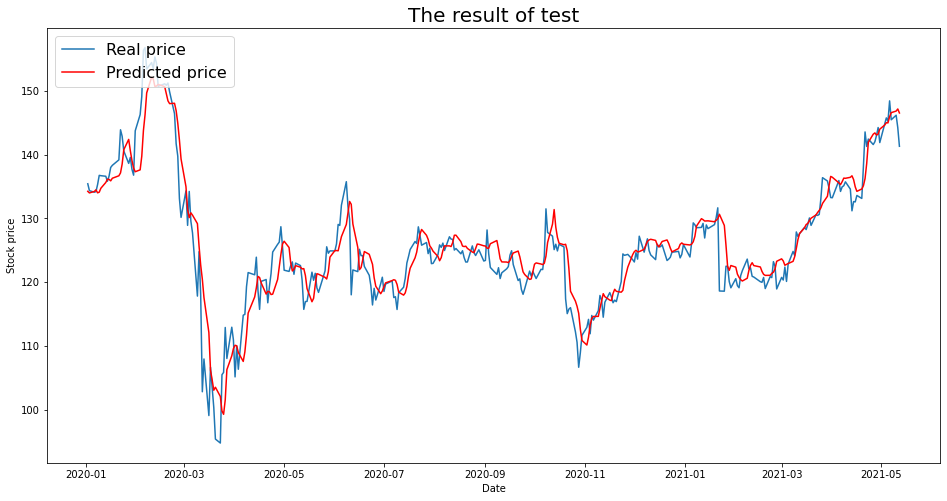

-- RMSE --  3.6827640253535256


<Figure size 864x576 with 0 Axes>

In [105]:
## Plot and save the test results to a csv file

test_predicted, test_RMSE = get_test_plot(X_test, y_test)
test_predicted.to_csv("test_predicted.csv")

In [106]:
## Print the shape of predecited test dataset

test_predicted.shape

(343, 344)

In [107]:
## Calculate RMSE

rmse_gan = np.sqrt(np.mean((df_price_ensemble['Actual_Price']-test_predicted['predicted_mean'])**2))
rmse_gan

3.6827640253535256

In [108]:
## Calculate MAPE  

mape_gan = np.mean(np.abs((df_price_ensemble['Actual_Price']-test_predicted['predicted_mean']) / df_price_ensemble['Actual_Price']))*100
mape_gan

2.0933363561365055

In [109]:
## Adding the predicted price from CNN Model into Ensemble dataframe

df_price_ensemble['Predicted_Price_GAN'] = test_predicted['predicted_mean']

### **Model 4 - RBFN**

In [110]:
## Create an Initializer Class

class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.
    # Arguments
        X: matrix, dataset to choose the centers from (random rows 
          are taken as centers)
    """
    def __init__(self, X):
        self.X = X 

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]
        idx = np.random.randint(self.X.shape[0], size=shape[0])
        return self.X[idx,:]

In [111]:
## Create a class for RBF Layer

class RBFLayer(Layer):
    """ Layer of Gaussian RBF units. 
    # Example
 
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X), 
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    
    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas 
    """
    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas 
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
            #self.initializer = Orthogonal()
        else:
            self.initializer = initializer 
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        
        self.centers = self.add_weight(name='centers', 
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(value=self.init_betas),
                                     #initializer='ones',
                                     trainable=True)
            
        super(RBFLayer, self).build(input_shape)  

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp( -self.betas * K.sum(H**2, axis=1))
        
        #C = self.centers[np.newaxis, :, :]
        #X = x[:, np.newaxis, :]

        #diffnorm = K.sum((C-X)**2, axis=-1)
        #ret = K.exp( - self.betas * diffnorm)
        #return ret 

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)


    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [112]:
## Function to calculate MAPE

def mean_absolute_percentage_error(y_true, y_pred): 
    
	y_true, y_pred = np.array(y_true), np.array(y_pred)
	
	return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [113]:
## Populate X & y dataframes from our dataset

dataset = df.iloc[:, [2,3]].values

X = df.iloc[:, 2].values
y = df.iloc[:, 3].values

In [114]:
# Feature Scaling

scaler  = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset)

X = dataset_scaled[:, 0]
y = dataset_scaled[:, 1]

In [115]:
# Splitting the dataset into the Training set and Test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [116]:
# Sizes of dataset, train_ds, test_ds

dataset_sz = X.shape[0]
train_sz = X_train.shape[0]
test_sz = X_test.shape[0]

In [117]:
## Reshape the train and test sets

X_train = np.reshape(X_train, (train_sz, 1))
y_train = np.reshape(y_train, (train_sz, 1))

In [118]:
## Building the RBF Model

# Initialising the RBF
regressor = Sequential()

# Adding the input layer and the first layer and Drop out Regularization
regressor.add(RBFLayer(500, initializer=InitCentersRandom(X_train),betas=2.0, input_shape=(1,)))
regressor.add(Dropout(.2))

# Adding the output layer
regressor.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the RBF
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RBF to the Training set
regressor.fit(X_train, y_train, batch_size = 32, epochs = 200)

Epoch 1/200
56/56 [==============================] - 1s 2ms/step - loss: 0.0117
Epoch 2/200
56/56 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 3/200
56/56 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 4/200
56/56 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 5/200
56/56 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 6/200
56/56 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 7/200
56/56 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 8/200
56/56 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 9/200
56/56 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 10/200
56/56 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 11/200
56/56 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 12/200
56/56 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 13/200
56/56 [=================

In [119]:
## Predict & Test the Model

real_stock_price = np.array(X_test)
inputs = real_stock_price
predicted_stock_price = regressor.predict(inputs)

24/24 [==============================] - 0s 1ms/step


In [120]:
## Rebuild the Structure

dataset_test_total = pd.DataFrame()
dataset_test_total['real'] = real_stock_price
dataset_test_total['predicted'] = predicted_stock_price

In [121]:
# Real data price VS. predicted price

predicted_stock_price = scaler.inverse_transform(dataset_test_total) 

In [122]:
## Calculate MSE

mse_rbfn = mean_squared_error(predicted_stock_price[:, 0], predicted_stock_price[:, 1])
mse_rbfn

3.6224883035243947

In [123]:
## Calculate RMSE

rmse_rbfn = np.sqrt(mse_rbfn)
rmse_rbfn

1.903283558360234

In [124]:
## Calculate MAPE    

mape_rbfn = mean_absolute_percentage_error(predicted_stock_price[:, 1], predicted_stock_price[:, 0])
mape_rbfn

1.13504651584107

In [125]:
## Visualizing the results

inputs = np.array(X)

all_real_price = np.array(y)
all_predicted_price = regressor.predict(inputs)

79/79 [==============================] - 0s 973us/step


In [126]:
# Rebuild the Structure

dataset_pred_real = pd.DataFrame()
dataset_pred_real.index = df['Date']
dataset_pred_real['real'] = all_real_price
dataset_pred_real['predicted'] = all_predicted_price

In [127]:
## Print the Index of Predicted dataset 

dataset_pred_real.index

DatetimeIndex(['2011-05-13', '2011-05-16', '2011-05-17', '2011-05-18',
               '2011-05-19', '2011-05-20', '2011-05-23', '2011-05-24',
               '2011-05-25', '2011-05-26',
               ...
               '2021-04-29', '2021-04-30', '2021-05-03', '2021-05-04',
               '2021-05-05', '2021-05-06', '2021-05-07', '2021-05-10',
               '2021-05-11', '2021-05-12'],
              dtype='datetime64[ns]', name='Date', length=2516, freq=None)

In [128]:
# Real test data price VS. predicted price

all_prices = scaler.inverse_transform(dataset_pred_real) 

In [129]:
## Create RBFN Dataframe to store Real & Predicted Stock Results

df_rbfn = pd.DataFrame(all_prices[:, 1], index=dataset_pred_real.index, columns=['real_stock_price'])
df_rbfn['predicted_stock_price'] = all_prices[:, 0]
df_rbfn.head()

,real_stock_price,predicted_stock_price
Date,,
2011-05-13,170.251273,173.062942
2011-05-16,168.738496,171.983898
2011-05-17,169.508769,170.284167
2011-05-18,169.288456,173.082040
2011-05-19,169.498746,172.948353


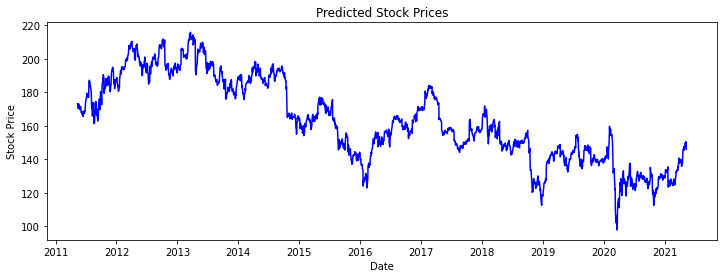

In [130]:
## Plot the Predicted Price Results

plt.figure(figsize=(12,4))
plt.plot(df_rbfn['predicted_stock_price'], color = 'blue', label = 'Predicted Stock Price')
plt.title('Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.savefig('Predicted_stock_price.png')
plt.show()

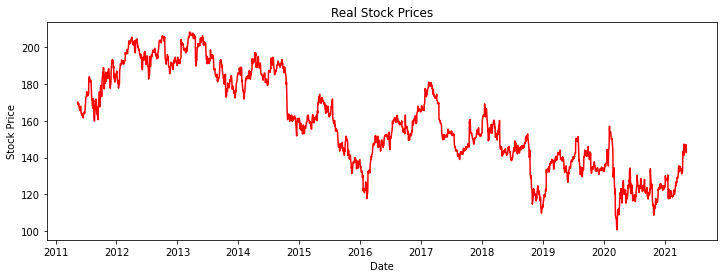

In [131]:
## Plot the Real Stock Prices

plt.figure(figsize=(12,4))
plt.plot(df_rbfn['real_stock_price'], color = 'red', label = 'Real Stock Price')
plt.title('Real Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.savefig('Real_stock_price.png')
plt.show()

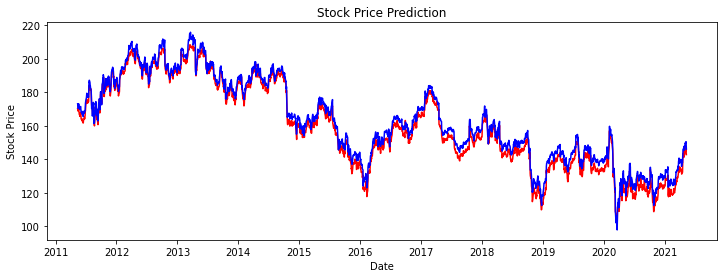

In [132]:
## Plot the Real & Predicted Prices together

plt.figure(figsize=(12,4))
plt.plot(df_rbfn['real_stock_price'], color = 'red', label = 'Real Stock Price')
plt.plot(df_rbfn['predicted_stock_price'], color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.savefig('stock_price_predicted_real.png')
plt.show()

In [133]:
df_price_ensemble['Predicted_Price_RBFN'] = df_rbfn['predicted_stock_price']

### **Step 4: Ensemble Model**

In [134]:
## Print the first few rows of ensemble dataframe

df_price_ensemble.head()

,Actual_Price,Predicted_Price_LSTM,Predicted_Price_CNN,Predicted_Price_GAN,Predicted_Price_RBFN
Date,,,,,
2020-01-02,135.42,132.869736,132.283905,134.237249,139.956465
2020-01-03,134.34,132.943710,132.109100,133.985170,138.800934
2020-01-06,134.10,132.998108,132.158890,134.217180,138.457168
2020-01-07,134.19,133.033157,131.789764,134.471866,138.648149
2020-01-08,135.31,133.049911,126.761040,134.001901,139.144700


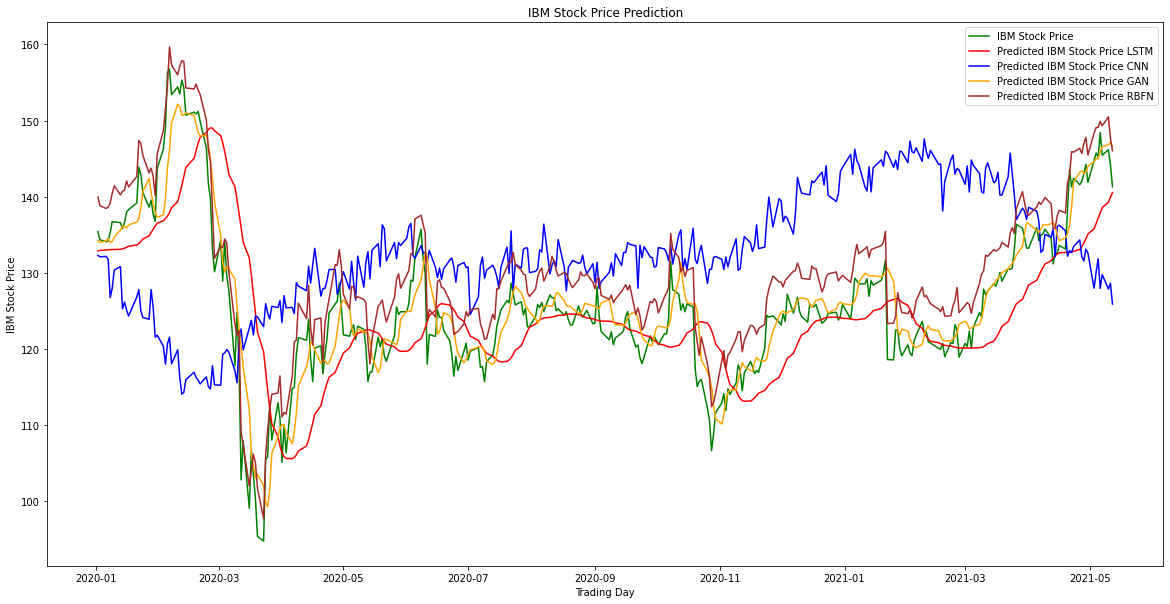

In [135]:
## Plot all the Model Results

plt.figure(figsize=(20,10))
plt.plot(df_price_ensemble['Actual_Price'], color = 'green', label = 'IBM Stock Price')
plt.plot(df_price_ensemble['Predicted_Price_LSTM'], color = 'red', label = 'Predicted IBM Stock Price LSTM')
plt.plot(df_price_ensemble['Predicted_Price_CNN'], color = 'blue', label = 'Predicted IBM Stock Price CNN')
plt.plot(df_price_ensemble['Predicted_Price_GAN'], color = 'orange', label = 'Predicted IBM Stock Price GAN')
plt.plot(df_price_ensemble['Predicted_Price_RBFN'], color = 'brown', label = 'Predicted IBM Stock Price RBFN')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()

In [136]:
## Calculate the Abg Predicted Price of all models and store in a new column

df_price_ensemble['Avg_Predicted_Price'] = (df_price_ensemble['Predicted_Price_LSTM'] + df_price_ensemble['Predicted_Price_CNN'] 
                                     + df_price_ensemble['Predicted_Price_GAN'] + df_price_ensemble['Predicted_Price_RBFN'])/4

In [137]:
## Print first few rows of ensemble dataframe

df_price_ensemble.head()

,Actual_Price,Predicted_Price_LSTM,Predicted_Price_CNN,Predicted_Price_GAN,Predicted_Price_RBFN,Avg_Predicted_Price
Date,,,,,,
2020-01-02,135.42,132.869736,132.283905,134.237249,139.956465,134.836835
2020-01-03,134.34,132.943710,132.109100,133.985170,138.800934,134.459725
2020-01-06,134.10,132.998108,132.158890,134.217180,138.457168,134.457833
2020-01-07,134.19,133.033157,131.789764,134.471866,138.648149,134.485738
2020-01-08,135.31,133.049911,126.761040,134.001901,139.144700,133.239386


In [138]:
## Calculate the RMSE of ensemble

rmse = np.sqrt(np.mean((df_price_ensemble['Actual_Price']-df_price_ensemble['Avg_Predicted_Price'])**2))
rmse

5.738542356619035

In [139]:
## Calculate the MAPE of ensemble
  
mape=np.mean(np.abs((df_price_ensemble['Actual_Price']-df_price_ensemble['Avg_Predicted_Price']) / df_price_ensemble['Actual_Price']))*100
mape

3.745433327391746

In [140]:
## Identify the most suited combination of ensemble

en_list = [[1,1,1,1], [1,2,0,1],[2,1,0,1],[1.5,1.5,0,1],[0,1,2,1], [0,2,1,1], [1.5,0,1.5,1],[0,1.5,1.5,1], [1,0,1,2],[2,0,0,2],[0,0,1,3], 
           [1,0,0,3],[0,1,0,3],[1,1,0,2],[0.5,0,1,2.5], [0,0,1.5,2.5], [0.5,0,0.5,3], [1,0,0.5,2.5]]
for i in en_list:
  df_price_ensemble['Avg_Predicted_Price'] = (df_price_ensemble['Predicted_Price_LSTM']*i[0] 
                                            + df_price_ensemble['Predicted_Price_CNN']*i[1]
                                            + df_price_ensemble['Predicted_Price_GAN']*i[2] 
                                            + df_price_ensemble['Predicted_Price_RBFN']*i[3])/4
  rmse = np.sqrt(np.mean((df_price_ensemble['Actual_Price']-df_price_ensemble['Avg_Predicted_Price'])**2))
  mape = np.mean(np.abs((df_price_ensemble['Actual_Price']-df_price_ensemble['Avg_Predicted_Price'])
                          /df_price_ensemble['Actual_Price']))*100
  print('RMSE for ' + str(i) + ' is ' + str(rmse))
  print('MAPE for ' + str(i) + ' is ' + str(mape))

RMSE for [1, 1, 1, 1] is 5.738542356619035
MAPE for [1, 1, 1, 1] is 3.745433327391746
RMSE for [1, 2, 0, 1] is 8.922913458247706
MAPE for [1, 2, 0, 1] is 6.025826309279216
RMSE for [2, 1, 0, 1] is 6.408182683276935
MAPE for [2, 1, 0, 1] is 3.972109563315297
RMSE for [1.5, 1.5, 0, 1] is 7.5210621414468095
MAPE for [1.5, 1.5, 0, 1] is 4.900468128821045
RMSE for [0, 1, 2, 1] is 5.433062565587233
MAPE for [0, 1, 2, 1] is 3.7039396988412547
RMSE for [0, 2, 1, 1] is 8.691790327376758
MAPE for [0, 2, 1, 1] is 6.092457228075818
RMSE for [1.5, 0, 1.5, 1] is 4.023479249403261
MAPE for [1.5, 0, 1.5, 1] is 2.2720358337404036
RMSE for [0, 1.5, 1.5, 1] is 7.013060150117187
MAPE for [0, 1.5, 1.5, 1] is 4.872435480158207
RMSE for [1, 0, 1, 2] is 3.3856711875112384
MAPE for [1, 0, 1, 2] is 2.1370054228050677
RMSE for [2, 0, 0, 2] is 4.171296701144657
MAPE for [2, 0, 0, 2] is 2.4352792989844976
RMSE for [0, 0, 1, 3] is 3.6666358476315937
MAPE for [0, 0, 1, 3] is 2.76039009134691
RMSE for [1, 0, 0, 3] is

In [141]:
## Print RMSE of individual Models

print('RMSE LSTM: ' + str(rmse_lstm))
print('RMSE_CNN: ' + str(rmse_cnn))
print('RMSE_GAN: ' + str(rmse_gan))
print('RMSE_RBFN: ' + str(rmse_rbfn))

RMSE LSTM: 7.685129552893544
RMSE_CNN: 15.434901040718918
RMSE_GAN: 3.6827640253535256
RMSE_RBFN: 1.903283558360234


In [142]:
## Print MAPE of individual Models

print('MAPE LSTM: ' + str(mape_lstm))
print('MAPE_CNN: ' + str(mape_cnn))
print('MAPE_GAN: ' + str(mape_gan))
print('MAPE_RBFN: ' + str(mape_rbfn))

MAPE LSTM: 4.43866180337923
MAPE_CNN: 10.60175647631922
MAPE_GAN: 2.0933363561365055
MAPE_RBFN: 1.13504651584107


RMSE for [0, 0, 1, 3] is 3.6666358476315937
MAPE for [0, 0, 1, 3] is 2.76039009134691


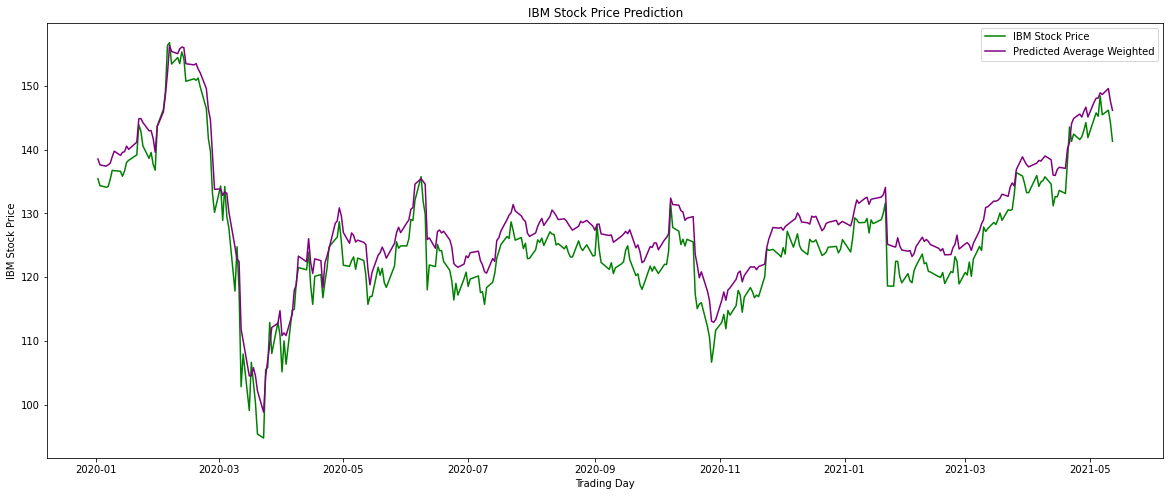

In [143]:
## Plot the graph for the suitable combination

en_list = [ [0,0,1,3]]
for i in en_list:
  df_price_ensemble['Avg_Predicted_Price'] = (df_price_ensemble['Predicted_Price_LSTM']*i[0] 
                                            + df_price_ensemble['Predicted_Price_CNN']*i[1] 
                                            + df_price_ensemble['Predicted_Price_GAN']*i[2] 
                                            + df_price_ensemble['Predicted_Price_RBFN']*i[3])/4
  # print(df_price_new.head(4))
  rmse = np.sqrt(np.mean((df_price_ensemble['Actual_Price']-df_price_ensemble['Avg_Predicted_Price'])**2))
  mape = np.mean(np.abs((df_price_ensemble['Actual_Price']-df_price_ensemble['Avg_Predicted_Price'])
                        /df_price_ensemble['Actual_Price']))*100
  print('RMSE for ' + str(i) + ' is ' + str(rmse))
  print('MAPE for ' + str(i) + ' is ' + str(mape))
plt.figure(figsize=(20,8))
plt.plot(df_price_ensemble['Actual_Price'], color = 'green', label = 'IBM Stock Price')
plt.plot(df_price_ensemble['Avg_Predicted_Price'], color = 'purple', label = 'Predicted Average Weighted')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('IBM Stock Price')

plt.legend()
plt.show()

Inference - The ensemble of LSTM, GAN & RBFN gives the best result and is most suitable Model. 